In [210]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib
import matplotlib.pyplot as plt
import math
import datetime


CSV_URL = "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv"

csv_string = requests.get(CSV_URL).content
df = pd.read_csv(io.StringIO(csv_string.decode('utf-8')))


In [211]:
origin_datetime = datetime.datetime.strptime(df['Date'][0], '%Y-%m-%d')
countries = {'Italy': None, 'France': None, 'Spain': None, 'US': None, 'China': None}
df.head()

,Date,Country,Confirmed,Deaths
0,2020-01-22,Afghanistan,0,0
1,2020-01-22,Albania,0,0
2,2020-01-22,Algeria,0,0
3,2020-01-22,Andorra,0,0
4,2020-01-22,Angola,0,0


In [212]:
df_plot = pd.DataFrame()
# show unique countries
#np.unique(df['Country'])
min_offset = 99999999999
for country in countries:
    print("Processing: {}".format(country))
    #cc = df[df['Country'] == country]['Confirmed'].values
    cc = df[df['Country'] == country]['Confirmed'].tolist()
    print("Initial Len: {}".format(len(cc)))
    countries[country] = 0
    #while cc.item(0) < 10:
    while cc[0] < 1000:
        cc = np.delete(cc, 0)
        cc = np.append(cc, [0])
        #cc.append([0])
        countries[country] += 1
    print("Final Len: {}, steps: {}".format(len(cc), countries[country]))
    df_plot[country] = cc
    if countries[country] < min_offset:
        min_offset = countries[country]


Processing: Italy
Initial Len: 66
Final Len: 66, steps: 38
Processing: France
Initial Len: 66
Final Len: 66, steps: 46
Processing: Spain
Initial Len: 66
Final Len: 66, steps: 47
Processing: US
Initial Len: 66
Final Len: 66, steps: 49
Processing: China
Initial Len: 66
Final Len: 66, steps: 3


In [213]:
df_plot.head()

,Italy,France,Spain,US,China
0,1128,1136,1073,1281,1406
1,1694,1219,1695,1663,2075
2,2036,1794,2277,2179,2877
3,2502,2293,2277,2727,5509
4,3089,2293,5232,3499,6087


Sim Italy[0] = 2007
Sim China[0] = 2345
Sim France[0] = 1463
Sim Spain[0] = 2659
Sim US[0] = 2209
Italy --> peak: Mar 22
China --> peak: Feb 16
France --> peak: Mar 30
Spain --> peak: Mar 31
US --> peak: Apr 02


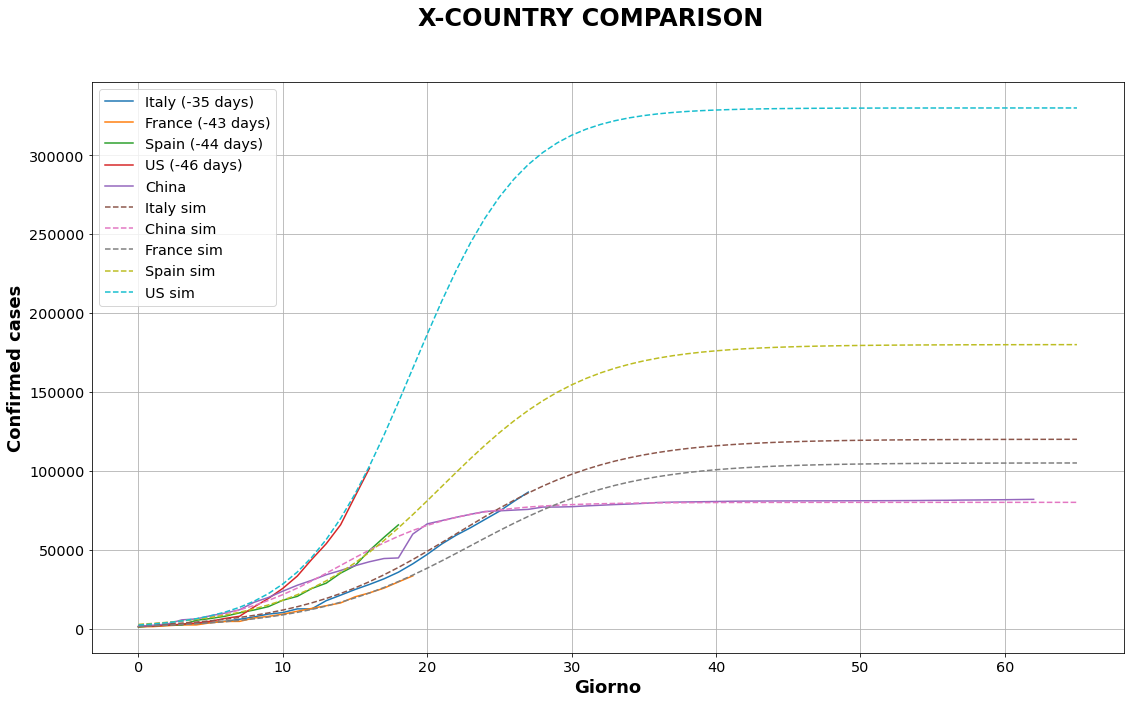

In [224]:
df_sim = pd.DataFrame()

A = {'Italy': 120000, 'China': 80000, 'France': 105000, 'Spain': 180000, 'US': 330000}
D = {'Italy': 22, 'China': 14, 'France': 23, 'Spain': 21, 'US': 19}
T = {'Italy': 5.4, 'China': 4, 'France': 5.4, 'Spain': 5, 'US': 3.8}

for country in ['Italy', 'China', 'France', 'Spain', 'US']:
    sim = [A[country] / (1+math.exp((D[country]-x)/T[country])) for x in range(0,len(df_plot[country]))]
    df_sim[country] = sim
    print("Sim {}[0] = {:.0f}".format(country, df_sim[country][0]))




fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('X-COUNTRY COMPARISON', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Confirmed cases', fontsize=18, fontweight='bold')

for country in countries:
    if countries[country] == min_offset:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{}".format(country))
    else:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{} (-{} days)".format(country, countries[country] - min_offset))

for country in ['Italy', 'China', 'France', 'Spain', 'US']:
    ax.plot(df_sim[country], label = "{} sim".format(country), linestyle='dashed')
    peak_datetime = origin_datetime + datetime.timedelta(days=countries[country] + D['Italy'])
    print("{} --> peak: {}".format(country, peak_datetime.strftime("%b %d")))
ax.grid()
ax.legend()

plt.show()






In [190]:
countries

{'Italy': 38, 'France': 46, 'Spain': 47, 'US': 49, 'China': 3}

In [191]:
pd.DataFrame(cc, columns = [country]).head()

,Spain
0,1406
1,2075
2,2877
3,5509
4,6087


In [192]:
np.unique(df['Country'])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burma', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'H